In [1]:
## Bring in packages
import pandas as pd
import numpy as np
import os
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.ticker as ticker
import cupy

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error

import scipy.stats as stats
import re
import shap
import seaborn as sns

from importlib import reload

## Change some settings
pd.set_option('display.max_columns', None)

In [2]:
## MAC 
## os.chdir('/Users/abrahambaldenegro/Documents/House Prediction Model/pythonProject')

## PC
os.chdir('C:/Users/abbal/OneDrive/Documents/GitHub/Rent-Pricing-Model-Description')
import ab
reload(ab)

ab.abe_says_hi()

abraham is ok


In [3]:
## Set working directory

## MAC
## os.chdir('/Users/abrahambaldenegro/Documents/House Prediction Model')

## PC
os.chdir('C:/Users/abbal/Documents/Data Science Personal Projects/Py - House Prediction')

RawData = pd.read_csv('apartments_for_rent_classified_100K.csv',
                     sep=";", encoding='cp1252', low_memory=False)

display(RawData.head(2))

,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,pets_allowed,price,price_display,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,5668640009,housing/rent/apartment,One BR 507 & 509 Esplanade,"This unit is located at 507 & 509 Esplanade, R...",NaN,1.0,1.0,USD,No,Thumbnail,Cats,2195.0,"$2,195",Monthly,542,507 509 Esplanade,Redondo Beach,CA,33.8520,-118.3759,RentLingo,1577360355
1,5668639818,housing/rent/apartment,Three BR 146 Lochview Drive,"This unit is located at 146 Lochview Drive, Ne...",NaN,1.5,3.0,USD,No,Thumbnail,"Cats,Dogs",1250.0,"$1,250",Monthly,1500,146 Lochview Dr,Newport News,VA,37.0867,-76.4941,RentLingo,1577360340


In [4]:
## Let's do some cleaning
RawData = ab.clean_data(df=RawData)

Rows before cleaning: 99,492
Rows after cleaning: 83,022
Removed 16,470 rows


In [5]:
## Add distance to nearest city
city_locations = pd.read_csv('City Locations.csv')
RawData = ab.get_city_features(df=RawData, city_locations=city_locations)

In [6]:
## Set up Other Features
RawData = ab.set_up_features(df=RawData)

In [7]:
## Get Feature Names
all_columns = RawData.columns

feature_vars = ['bathrooms', 'bedrooms',
                'square_feet', 'body_length',
                'amenities_parking', 'amenities_gym', 'amenities_pool',
                'amenities_washer', 'photo_thumbnail', 
                'pets_dogs', 'pets_cat', 'distance_to_closest_city'] + [text for text in all_columns if re.search('^city_', text)] + [text for text in all_columns if re.search('^state_', text)]

prediction_var = "price"

In [8]:
## Drop Rows where any feature is missing
RawData = ab.remove_empty_rows(df=RawData, cols = feature_vars)

Dropping Selected Columns...
Dropped 113 out of 83,022 rows


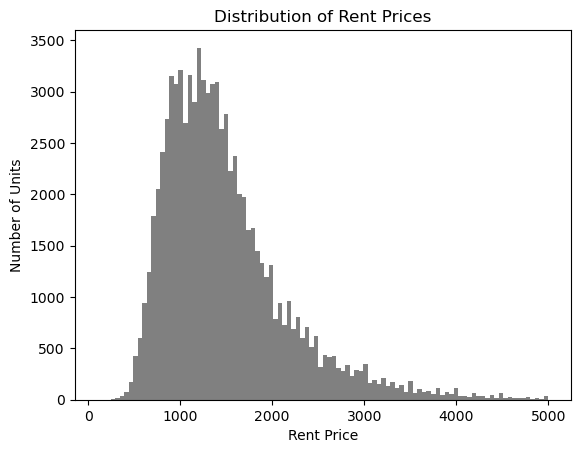

In [9]:
## Let's do some explorations
plt.hist(RawData['price'], bins = 100, color="grey")
plt.ylabel("Number of Units")
plt.xlabel("Rent Price")
plt.title("Distribution of Rent Prices")
plt.show()

In [10]:
## Check distribution of Prices
display(RawData['price'].quantile([0.2, 0.40, .60, 0.80]))

0.2     950.0
0.4    1212.0
0.6    1485.0
0.8    1905.0
Name: price, dtype: float64

In [11]:
## Create buckets of prices
RawData = ab.create_price_bins(df=RawData)

price_cat
01 - Very Low Price (<$1K)            19987
03 - Medium Price ($1.2K to $1.5K)    18507
04 - High Price ($1.5K to $2K)        17911
02 - Low Price ($1K to $1.2K)         12144
05 - Very High Price ($2K to $3K)     11231
06 - Highly Premium ($3K+)             3129
Name: count, dtype: int64

In [12]:
display(RawData)

,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,pets_allowed,price,price_display,price_type,square_feet,address,cityname,latitude,longitude,source,time,distance_to_closest_city,city_albuquerque,city_anaheim,city_anchorage,city_arlington,city_atlanta,city_aurora,city_austin,city_bakersfield,city_baltimore,city_boise,city_boston,city_buffalo,city_chandler,city_charlotte,city_chesapeake,city_chicago,city_chula_vista,city_cincinnati,city_cleveland,city_colorado_springs,city_columbus,city_corpus_christi,city_dallas,city_denver,city_detroit,city_durham,city_el_paso,city_enterprise,city_fort_wayne,city_fort_worth,city_fremont,city_fresno,city_garland,city_gilbert,city_glendale,city_greensboro,city_henderson,city_honolulu,city_houston,city_indianapolis,city_irvine,city_jacksonville,city_jersey_city,city_kansas_city,city_laredo,city_las_vegas,city_lexington,city_lincoln,city_long_beach,city_los_angeles,city_louisville,city_lubbock,city_madison,city_memphis,city_mesa,city_miami,city_milwaukee,city_minneapolis,city_nashville,city_new_orleans,city_new_york_city,city_newark,city_norfolk,city_north_las_vegas,city_oakland,city_oklahoma_city,city_omaha,city_orlando,city_philadelphia,city_phoenix,city_pittsburgh,city_plano,city_portland,city_raleigh,city_reno,city_riverside,city_sacramento,city_san_antonio,city_san_diego,city_san_francisco,city_san_jose,city_santa_ana,city_santa_clarita,city_scottsdale,city_seattle,city_st_louis,city_st_paul,city_st_petersburg,city_stockton,city_tampa,city_toledo,city_tucson,city_tulsa,city_virginia_beach,city_washington_dc,city_wichita,city_winston-salem,body_length,amenities_parking,amenities_gym,amenities_pool,amenities_washer,photo_thumbnail,pets_dogs,pets_cat,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,price_cat
21,5668632369,housing/rent/apartment,One BR 7011 W PARMER LN,"This unit is located at 7011 W PARMER LN, Aust...","Fireplace,Gym,Parking,Pool,Storage,Wood Floors",1.0,1.0,USD,No,Thumbnail,NaN,1060.0,"$1,060",Monthly,650,7011 W Parmer Lane,Austin,30.3054,-97.7497,RentLingo,1577359827,0.004610,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,152,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,02 - Low Price ($1K to $1.2K)
22,5668632002,housing/rent/apartment,One BR 2800 SUNRISE RD,"This unit is located at 2800 SUNRISE RD, Round...","Gated,Pool",1.0,1.0,USD,No,Thumbnail,NaN,1003.0,"$1,003",Monthly,797,2800 Sunrise Road,Round Rock,30.5118,-97.6873,RentLingo,1577359796,0.211316,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,156,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,02 - Low Price ($1K to $1.2K)
23,5668631854,housing/rent/apartment,One BR 12330 METRIC BLVD.,"This unit is located at 12330 METRIC BLVD., Au...","Dishwasher,Parking,Pool",1.0,1.0,USD,No,Thumbnail,NaN,837.0,$837,Monthly,444,12330 Metric Boulevard,Austin,30.3054,-97.7497,RentLingo,1577359784,0.004610,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,152,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [ ]:
with pd.option_context("display.max_rows", 1000):
    display(RawData[['price_cat'] + feature_vars].groupby('price_cat').mean().apply(lambda s: s.apply('{0:.3f}'.format)).T)

In [13]:
RawData[['price_cat'] + feature_vars].describe().style.format("{:,.2f}")

,bathrooms,bedrooms,square_feet,body_length,amenities_parking,amenities_gym,amenities_pool,amenities_washer,photo_thumbnail,pets_dogs,pets_cat,distance_to_closest_city,city_albuquerque,city_anaheim,city_anchorage,city_arlington,city_atlanta,city_aurora,city_austin,city_bakersfield,city_baltimore,city_boise,city_boston,city_buffalo,city_chandler,city_charlotte,city_chesapeake,city_chicago,city_chula_vista,city_cincinnati,city_cleveland,city_colorado_springs,city_columbus,city_corpus_christi,city_dallas,city_denver,city_detroit,city_durham,city_el_paso,city_enterprise,city_fort_wayne,city_fort_worth,city_fremont,city_fresno,city_garland,city_gilbert,city_glendale,city_greensboro,city_henderson,city_honolulu,city_houston,city_indianapolis,city_irvine,city_jacksonville,city_jersey_city,city_kansas_city,city_laredo,city_las_vegas,city_lexington,city_lincoln,city_long_beach,city_los_angeles,city_louisville,city_lubbock,city_madison,city_memphis,city_mesa,city_miami,city_milwaukee,city_minneapolis,city_nashville,city_new_orleans,city_new_york_city,city_newark,city_norfolk,city_north_las_vegas,city_oakland,city_oklahoma_city,city_omaha,city_orlando,city_philadelphia,city_phoenix,city_pittsburgh,city_plano,city_portland,city_raleigh,city_reno,city_riverside,city_sacramento,city_san_antonio,city_san_diego,city_san_francisco,city_san_jose,city_santa_ana,city_santa_clarita,city_scottsdale,city_seattle,city_st_louis,city_st_paul,city_st_petersburg,city_stockton,city_tampa,city_toledo,city_tucson,city_tulsa,city_virginia_beach,city_washington_dc,city_wichita,city_winston-salem,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
count,"82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00","82,909.00"
mean,1.44,1.71,943.76,843

In [66]:
## Set up data for model

## Data Processing ##
X = RawData[feature_vars]
y = RawData['price']

print(f"The average price is ${np.mean(y):,.2f}")

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 97)

The average price is $1,485.28


In [67]:
## Set up table for XGBOOST ##
xgDMatrix = xgb.DMatrix(X, y)
xgbDMatrixTrain = xgb.DMatrix(X_train, y_train)
xgbDMatrixTest = xgb.DMatrix(X_test, y_test)

eval_set = [(xgbDMatrixTest, 'Test'), (xgbDMatrixTrain, 'Train')]
evals_result_base = {}

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 15,
    'learning_rate':0.15,
    "device": "cpu",
    "tree_method": "hist"
}

In [68]:
base_model = xgb.train(params = params,
                       dtrain = xgbDMatrixTrain,
                       num_boost_round=1000,
                       evals=eval_set,
                       obj=None,
                       evals_result=evals_result_base,
                       verbose_eval=100)

[0]	Test-rmse:598.13596	Train-rmse:596.58163
[100]	Test-rmse:270.11622	Train-rmse:117.98047
[200]	Test-rmse:263.52277	Train-rmse:71.20948
[300]	Test-rmse:261.70031	Train-rmse:44.56253
[400]	Test-rmse:261.28972	Train-rmse:29.66779
[500]	Test-rmse:261.21950	Train-rmse:21.78878
[600]	Test-rmse:261.15045	Train-rmse:17.24446
[700]	Test-rmse:261.16865	Train-rmse:14.83974
[800]	Test-rmse:261.21707	Train-rmse:13.53867
[900]	Test-rmse:261.24574	Train-rmse:13.05745
[999]	Test-rmse:261.26823	Train-rmse:12.84192


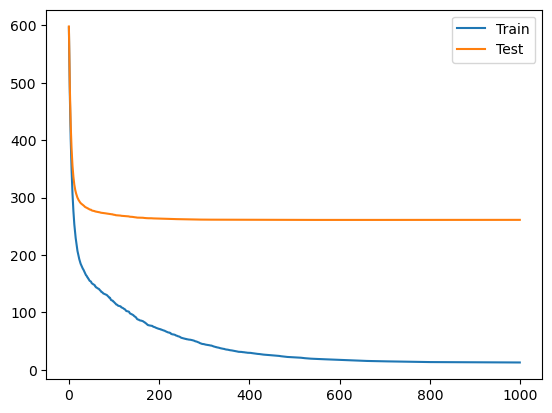

In [45]:
# plot learning curves
pyplot.plot(evals_result_base['Train']['rmse'], label='Train')
pyplot.plot(evals_result_base['Test']['rmse'], label='Test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

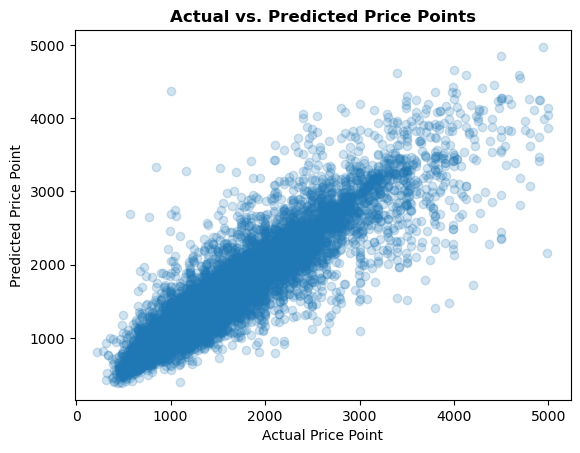

In [69]:
## Check if predictions align with actual (on the test set)
pred_y = base_model.predict(xgbDMatrixTest)

plt.scatter(x = y_test, y = pred_y, alpha=0.2)
plt.title('Actual vs. Predicted Price Points', weight='bold')
plt.xlabel('Actual Price Point')
plt.ylabel('Predicted Price Point')
plt.show()

In [75]:
## TO Export:

pred_y_test  = base_model.predict(xgbDMatrixTest)
pred_y_train = base_model.predict(xgbDMatrixTrain)

pred_y_test = pd.DataFrame({'predicted_price': pred_y_test},  index=X_test.index)
pred_y_train = pd.DataFrame({'predicted_price': pred_y_train},  index=X_train.index)

test_full = pd.concat([X_test, pred_y_test], axis = 1)
test_full['train_vs_test'] = 'Test'

train_full = pd.concat([X_train, pred_y_train], axis = 1)
train_full['train_vs_test'] = 'Train'

final_export = pd.concat([test_full, train_full], axis = 0)
final_export.to_csv("Output For Tableau.csv")

################################
## Create Columns for Tableau ##
################################

bedroom_conditions = [
    (final_export['bedrooms'] == 0),
    (final_export['bedrooms'] == 1),
    (final_export['bedrooms'] == 2),
    (final_export['bedrooms'] == 3),
    (final_export['bedrooms'] >= 4)
]

bedroom_names = [
    '01 - Studio',
    '02 - One Bedroom',
    '03 - Two Bedrooms',
    '04 - Three Bedrooms',
    '05 - Four or more',
]

size_conditions = [
    (final_export['square_feet'] < 700),
    (final_export['square_feet'] >= 700) & (final_export['square_feet'] < 850),
    (final_export['square_feet'] >= 850) & (final_export['square_feet'] < 1000),
    (final_export['square_feet'] >= 1000)
]

bedroom_names = [
    '01 - Small (<700sqft)',
    '02 - Medium (700 to 850sqft)',
    '03 - Large (850 to 1,000sqft)',
    '04 - Very large (1,000sqft+)',
]

    RawData['bedroom_cat'] = np.select(conditions, category_names, default='Unknown')



In [ ]:
################
## Tune model ##
################

# Define the hyperparameter distributions
param_dist = {
     'learning_rate' : [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.40],
     'max_depth' : [5, 6, 10, 12, 15, 20, 25, 40, 60],
     'min_child_weight' : [1, 3, 5, 7],
     'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4],
     'colsample_bytree' : [0.3, 0.4, 0.5, 0.7],
     'n_estimators': [20,50,100,200,500,1000]
}

# Create the XGBoost model object
xgb_model = xgb.XGBRegressor(tree_method="hist", device="cuda")

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(xgb_model, 
                                   param_distributions=param_dist, 
                                   n_iter=500, 
                                   cv=3, 
                                   scoring='neg_root_mean_squared_error',
                                   verbose = 3)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(cupy.array(X_train), y_train)

# Print the best set of hyperparameters and the corresponding score
best_hyperparameters = random_search.best_params_
best_score = random_search.best_score_

print("Best set of hyperparameters: ", best_hyperparameters)
print("Best score: ", best_score)

In [ ]:
## Need to tweak one parameter
evals_result_optimized = {}

try:
    opt_num_rounds = best_hyperparameters['n_estimators']
    del best_hyperparameters['n_estimators']
except:
    None

model_optimized = xgb.train(params = best_hyperparameters,
                            dtrain = xgDMatrix,
                            evals=eval_set,
                            num_boost_round=opt_num_rounds,
                            obj=None,
                            evals_result=evals_result_optimized,
                            verbose_eval=100)

In [ ]:
## Let's see how the optimized model compares to the base model
pyplot.plot(evals_result_base['Test']['rmse'], label='Base (test)')
pyplot.plot(evals_result_optimized['Test']['rmse'], label='Optimimized (tet)')

pyplot.title('Learning Curves for Base vs. Optimized XGB Model')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
##########
## Shap ##
##########

sample_x_test = X_test.sample(10000)
explainer = shap.Explainer(model_optimized, sample_x_test)

# Calculate SHAP values
shap_values = explainer(sample_x_test)

# Visualize the SHAP values (optional)
shap.summary_plot(shap_values, sample_x_test)

In [ ]:
new_category_names = [
                    'Very Low (<$1K)',
                    'Low (\\$1K to \\$1.2K)',
                    'Medium (\\$1.2K to \\$1.5K)',
                    'High (\\$1.5K to \\$2K)',
                    'Very High (\\$2K to \\$3K)',
                    'Premium (\\$3K+)'
                   ]

## Boxplot
predicted_price = pd.DataFrame({'price_actual':y_test,
                                'price':pred_y})

predicted_price = ab.create_price_bins(df=predicted_price, print_results=False, category_names=new_category_names)

predicted_price.rename(columns={'price_cat': 'Predicted Price Category'}, inplace=True)


sns.set(rc={'figure.figsize':(11,8)}, font_scale=0.8, style='whitegrid')
sns.boxplot(data=predicted_price, 
            x='Predicted Price Category', 
            y='price_actual',
            order = new_category_names,
            width=0.6,
            whis=0.95).set(
    xlabel='Predicted Price Bucket', 
    ylabel='Actual Rent Price'
)
plt.title('Distribution of Actual Rent Prices by Predicted Groups')
plt.show()

In [ ]:
sns.kdeplot(
   data=predicted_price, x="price_actual", hue='Predicted Price Category',
   fill=True, common_norm=False, palette="crest",
   alpha=.5, linewidth=0, hue_order=new_category_names).set(
    xlabel='Actual Rent Price', 
)
plt.title('Distribution of Actual Rent Prices by Predicted Groups')
plt.show()

In [ ]:
print("hello")